In [18]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
zip_file_path = "/content/drive/MyDrive/CSE475LAB1/MangoLeafBD Dataset (1).zip"

In [21]:
import zipfile
import os

# Define the path to your ZIP file
zip_file_path = "/content/drive/MyDrive/CSE475LAB1/MangoLeafBD Dataset (1).zip"  # Replace with your file path

# Define the extraction path
extraction_path = "/content/drive/MyDrive/CSE475LAB1"  # This will extract the dataset in Colab's filesystem

# Extract the ZIP file
os.makedirs(extraction_path, exist_ok=True)
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_path)

print(f"Dataset extracted to: {extraction_path}")

Dataset extracted to: /content/drive/MyDrive/CSE475LAB1


In [12]:
# List the categories (subdirectories) in the dataset
categories = os.listdir(extraction_path)
print(f"Categories found: {categories}")

Categories found: ['MangoLeafBD Dataset']


In [22]:
from torchvision import datasets, transforms
from torch.utils.data import random_split

# Define transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize all images to 128x128
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.RandomGrayscale(p=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

# Load the dataset using ImageFolder
dataset = datasets.ImageFolder(root=extraction_path, transform=transform)
print(f"Total images in dataset: {len(dataset)}")

Total images in dataset: 8800


In [23]:
# Import libraries
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from collections import Counter





In [25]:
# Set directory path to the dataset
data_dir = '/content/drive/MyDrive/CSE475LAB1/MangoLeafBD Dataset'  # Update this path as needed
categories = ["Anthracnose", "Bacterial Canker", "Cutting Weevil", "Die Back",
              "Gall Midge", "Healthy", "Powdery Mildew", "Sooty Mould"]

# Function to load images and labels
def load_images(data_dir, categories, img_size=(128, 128)):
    images = []
    labels = []
    avg_colors = []
    for label, category in enumerate(categories):
        path = os.path.join(data_dir, category)
        if not os.path.isdir(path):
            print(f"Directory not found: {path}")
            continue
        for img_name in os.listdir(path):
            img_path = os.path.join(path, img_name)
            try:
                img = cv2.imread(img_path)
                img = cv2.resize(img, img_size)
                images.append(img)
                labels.append(label)
                avg_colors.append(cv2.mean(img)[:3])  # BGR average
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")
    return np.array(images), np.array(labels), np.array(avg_colors)

# Load images, labels, and average color information
images, labels, avg_colors = load_images(data_dir, categories)

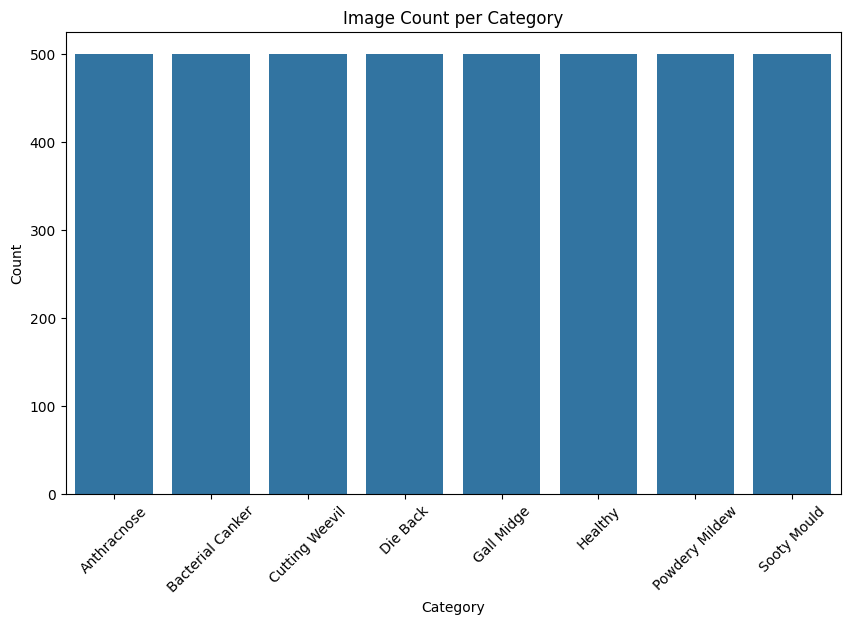

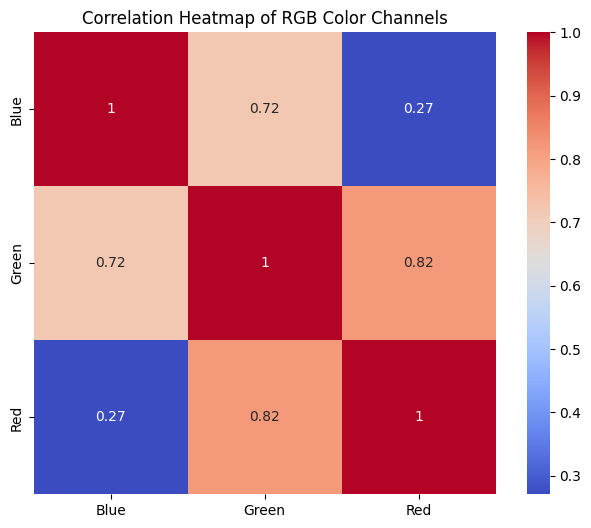

Category Summary Table


,Category,Image Count,Avg Blue,Avg Green,Avg Red
0,Anthracnose,500,177.381043,181.291865,175.884111
1,Bacterial Canker,500,161.357619,173.474733,174.161276
2,Cutting Weevil,500,198.101516,176.394646,152.015702
3,Die Back,500,188.665198,171.646450,160.609038
4,Gall Midge,500,171.364578,179.479750,180.386189
5,Healthy,500,173.119382,184.125183,180.827063
6,Powdery Mildew,500,164.235554,168.028189,166.434599
7,Sooty Mould,500,162.735904,175.105250,175.701873


In [26]:
# Step 2: EDA with Visualizations

# 1. Display Category Distribution
category_counts = Counter(labels)
plt.figure(figsize=(10, 6))
sns.barplot(x=list(category_counts.keys()), y=list(category_counts.values()))
plt.xticks(range(len(categories)), categories, rotation=45)
plt.title('Image Count per Category')
plt.xlabel('Category')
plt.ylabel('Count')
plt.show()

# 2. Average Color Correlation Heatmap
color_df = pd.DataFrame(avg_colors, columns=['Blue', 'Green', 'Red'])
plt.figure(figsize=(8, 6))
sns.heatmap(color_df.corr(), annot=True, cmap='coolwarm', square=True)
plt.title("Correlation Heatmap of RGB Color Channels")
plt.show()

# 3. Average Color Intensity by Category
summary_data = {
    "Category": categories,
    "Image Count": [category_counts[cat] for cat in range(len(categories))],
    "Avg Blue": [np.mean(avg_colors[labels == cat, 0]) for cat in range(len(categories))],
    "Avg Green": [np.mean(avg_colors[labels == cat, 1]) for cat in range(len(categories))],
    "Avg Red": [np.mean(avg_colors[labels == cat, 2]) for cat in range(len(categories))]
}
summary_df = pd.DataFrame(summary_data)

# Display the summary table
print("Category Summary Table")
display(summary_df)

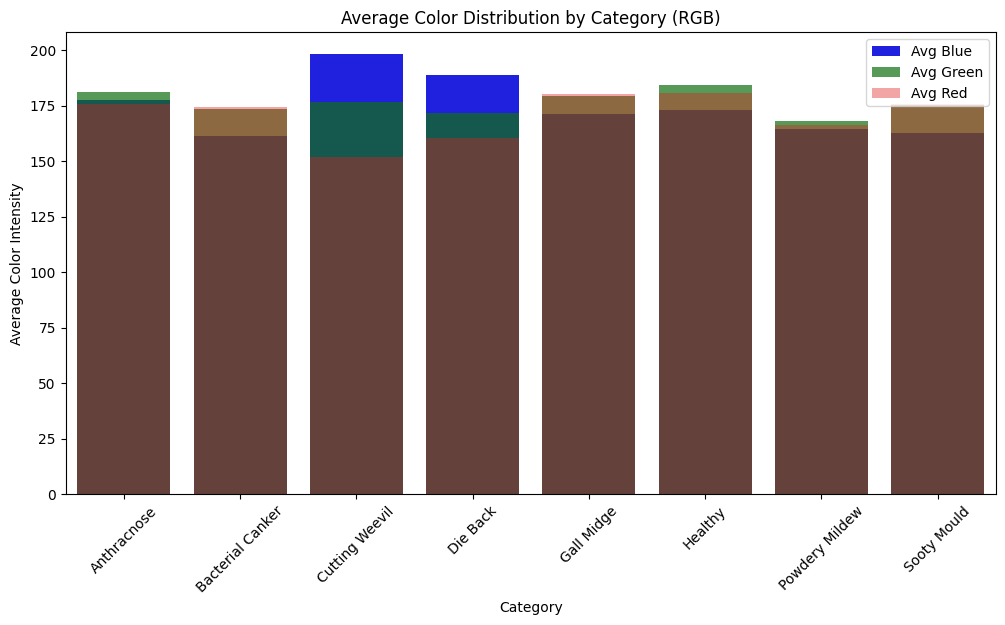

In [27]:
# Visualization of Average Color Intensity by Category
plt.figure(figsize=(12, 6))
sns.barplot(x='Category', y='Avg Blue', data=summary_df, color='b', label="Avg Blue")
sns.barplot(x='Category', y='Avg Green', data=summary_df, color='g', label="Avg Green", alpha=0.7)
sns.barplot(x='Category', y='Avg Red', data=summary_df, color='r', label="Avg Red", alpha=0.4)
plt.title("Average Color Distribution by Category (RGB)")
plt.xticks(rotation=45)
plt.xlabel("Category")
plt.ylabel("Average Color Intensity")
plt.legend()
plt.show()

In [28]:
# Step 3: Model Training - Preprocessing and Feature Extraction

# Flatten images for feature extraction
flat_images = images.reshape(len(images), -1)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(flat_images, labels, test_size=0.3, random_state=42)

# Initialize models
dt_model = DecisionTreeClassifier(random_state=42)
rf_model = RandomForestClassifier(random_state=42)

# Train and evaluate Decision Tree
dt_model.fit(X_train, y_train)
y_pred_dt = dt_model.predict(X_test)
print("Decision Tree Performance:\n", classification_report(y_test, y_pred_dt, target_names=categories))

# Train and evaluate Random Forest
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
print("Random Forest Performance:\n", classification_report(y_test, y_pred_rf, target_names=categories))

Decision Tree Performance:
                   precision    recall  f1-score   support

     Anthracnose       0.64      0.62      0.63       167
Bacterial Canker       0.73      0.76      0.74       148
  Cutting Weevil       0.86      0.95      0.90       158
        Die Back       0.81      0.82      0.81       149
      Gall Midge       0.58      0.57      0.58       159
         Healthy       0.67      0.71      0.69       135
  Powdery Mildew       0.55      0.50      0.52       134
     Sooty Mould       0.48      0.45      0.46       150

        accuracy                           0.67      1200
       macro avg       0.66      0.67      0.67      1200
    weighted avg       0.67      0.67      0.67      1200

Random Forest Performance:
                   precision    recall  f1-score   support

     Anthracnose       0.87      0.87      0.87       167
Bacterial Canker       0.87      0.88      0.87       148
  Cutting Weevil       0.94      0.97      0.96       158
        Die 